# Corrected estimate of the reproduction ratio from surveillance data

This code is meant to implement the method to estimate the reproduction number of an infectious disease proposed in *Estimates of the reproduction ratio from epidemic surveillance may be biased in spatially structured populations*, Birello, Re Fiorentin, Wang, Colizza, Valdano.
Preprint: https://arxiv.org/abs/2307.13798.

Required inputs are:
* a time series of reported or estimated infections in a number of spatial patches the geographic region under study is divided into;
* a co-location matrix, that accounts for the mobility patterns between the spatial patches;
* the population of spatial patches.

Examples of input files can be found in this repository, in order to facilitate the use of this code.

## Imports

In [1]:
import numpy as np
import pandas as pd
import scipy.linalg
import epyestim.covid19 as covid19
from epyestim import bagging_r
import matplotlib.pyplot as plt

## Read data

In [2]:
# Colocation data
colocation_matrix=pd.read_csv('Matrix_Example',index_col=0)     

# Populations of departments
departments_population=pd.read_csv('Populations_Example',index_col=0)
departments_population=pd.Series(departments_population.iloc[:,0])

# New infections in departments
new_infections_departments = pd.read_csv('Cases_Example', index_col=0)

N = departments_population.shape[0]

## Compute the reproduction operator and $v^*$, then obtain corrected incidence  

In [3]:
# Obtain reproduction operator
R = colocation_matrix.mul(departments_population,axis=0)

# Compute left eigenvector (note that it has real entries)
w,vl,vr=scipy.linalg.eig(R.to_numpy(),left=True)
v_star=vl[:,w.argmax()]/np.sum(vl[:,w.argmax()])
v_star=pd.Series(v_star.real)  
v_star.set_axis(R.columns,inplace=True)

# Compute new infections globally
new_infections = new_infections_departments.copy()
new_infections['total'] = new_infections.iloc[:,1:].sum(axis=1) 
new_infections['date']=pd.to_datetime(new_infections['date'])
new_infections = new_infections.set_index('date')['total']

# Compute new infections corrected, i.e., weighted by v_star)
new_infections_corr = new_infections_departments.copy()
new_infections_corr.iloc[:,1:]=new_infections_corr.iloc[:,1:].mul(v_star*N,axis=1)
new_infections_corr['total'] = new_infections_corr.iloc[:,1:].sum(axis=1) 
new_infections_corr['date']=pd.to_datetime(new_infections_corr['date'])
new_infections_corr=new_infections_corr.set_index('date')['total']

#display
display(new_infections.head())
display(new_infections_corr.head())

date
2020-03-03     7125.00
2020-03-04     9093.75
2020-03-05    11000.00
2020-03-06    14406.25
2020-03-07    18812.50
Name: total, dtype: float64

date
2020-03-03     3181.176412
2020-03-04    16014.563452
2020-03-05    19846.009720
2020-03-06    16875.796955
2020-03-07    35403.480626
Name: total, dtype: float64

## EpiEstim

We will now compute our estimates of the reproduction ratio. Some inputs will be required. 
* generation interval distribution;
* distribution of delay from infection to reporting;
* smoothing window, i.e., the size of the rolling window;
* r_window_size, i.e., the minimum time needed to obtain realiable estimates of the reproduction ratio;
* $a, b$, i.e., the prior parameters of the Gamma distribution used to estimate the reproduction ratio. The default choice of the authors of the method is $a=1, b=5$, giving mean 5 and standard deviation 5.

See the documentation at https://pypi.org/project/epyestim/ for futher information.

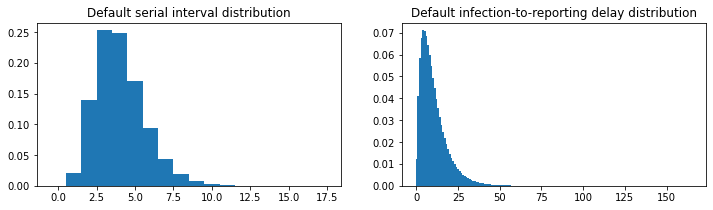

In [4]:
# Insert your generation interval distribution. As an example, here we set a generation interval distribution for COVID-19.
si_distrb = covid19.generate_standard_si_distribution()
# Insert your distribution of delay from infection to reporting. As an example, here we set a distribution of delay for COVID-19
delay_distrb = covid19.generate_standard_infection_to_reporting_distribution()

# Visualize the distributions
fig, axs = plt.subplots(1, 2, figsize=(12,3))
axs[0].bar(range(len(si_distrb)), si_distrb, width=1)
axs[1].bar(range(len(delay_distrb)), delay_distrb, width=1)
axs[0].set_title('Default serial interval distribution')
axs[1].set_title('Default infection-to-reporting delay distribution')
plt.show()

In [5]:
# Estimate the reproduction number
estimated_R = bagging_r( confirmed_cases=new_infections, gt_distribution=si_distrb, delay_distribution=delay_distrb, smoothing_window=7, r_window_size=7, a_prior=1, b_prior=5)
# Estimate the proposed corrected reproduction number
estimated_R_corr = bagging_r( confirmed_cases=new_infections_corr, gt_distribution=si_distrb, delay_distribution=delay_distrb, smoothing_window=7, r_window_size=7, a_prior=1, b_prior=5)

display(estimated_R.head())
display(estimated_R_corr.head())

,cases,R_mean,R_var,Q0.025,Q0.5,Q0.975
2020-03-10,34718.0,2.026049,0.000007,2.020756,2.026048,2.031349
2020-03-11,43718.0,1.728224,0.000005,1.723871,1.728223,1.732583
2020-03-12,49187.0,1.528016,0.000004,1.524292,1.528015,1.531743
2020-03-13,60687.0,1.428968,0.000003,1.425619,1.428968,1.432322
2020-03-14,52281.0,1.416105,0.000003,1.412950,1.416105,1.419264


,cases,R_mean,R_var,Q0.025,Q0.5,Q0.975
2020-03-10,27619.0,0.931790,0.000003,0.928392,0.931788,0.935193
2020-03-11,35985.0,0.779311,0.000002,0.776283,0.779310,0.782344
2020-03-12,30478.0,0.832657,0.000003,0.829517,0.832656,0.835804
2020-03-13,29359.0,1.097241,0.000004,1.093562,1.097240,1.100927
2020-03-14,37333.0,1.535522,0.000005,1.531048,1.535521,1.540003


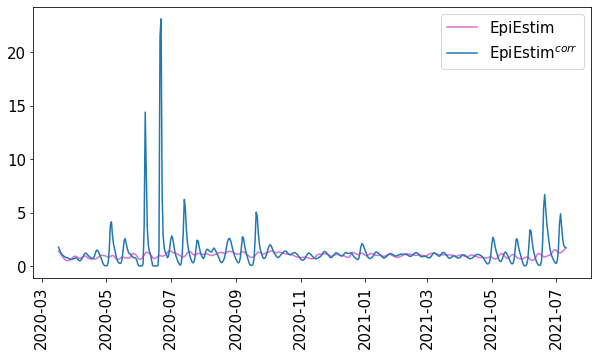

In [6]:
# Plot the result
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(estimated_R.index[7:],estimated_R['R_mean'][7:],color='orchid',label='EpiEstim')
ax.plot(estimated_R_corr.index[7:],estimated_R_corr['R_mean'][7:],color='tab:blue',label=r'EpiEstim$^{corr}$')
ax.tick_params(axis='x',labelsize=15,rotation=90)
ax.tick_params(axis='y',labelsize=15)
_=ax.legend(fontsize=15)

Note: The above figure was obtained using a randomly generated co-location matrix, and should be treated as such.